# 0. Understanding log-polar stimuli

In [2]:
import os
import sys
sys.path.append('..')
sys.path.append('/Users/jh7685/Github/spatial-frequency-preferences')
from sfp import stimuli
from pandas.core.common import SettingWithCopyWarning
import pandas as pd
import numpy as np
from sfp_nsdsyn import save_stimuli_description
from sfp_nsdsyn import prep
import warnings 

warnings.filterwarnings("ignore", category=SettingWithCopyWarning)
%load_ext autoreload
%autoreload 2

In [3]:
design_mat_path = os.path.join('/Volumes/server/Projects/sfp_nsd/natural-scenes-dataset', 'nsddata', 'experiments', 'nsdsynthetic', 'nsdsynthetic_expdesign.mat')
trial_orders = prep._load_exp_design_mat(design_mat_path)


# Download the log polar stimuli description file from OSF 
The Natural Scenes Dataset also used log-polar stimuli as described in Broderick et al. (2024). Although they were created in the same manner, there are differences in the stimulus design parameters, including the number of phase shifts and the values of w_r and w_a (see Ha et al., Table 1).

We will begin by downloading the stimulus information file from [OSF](https://osf.io/hcu78), which is provided in .csv format. This file was used to generate the log-polar stimuli presented in the NSD synthetic experiment.


In [2]:
prep.download_stim_info_csv(save_path='/Volumes/server/Projects/sfp_nsd/natural-scenes-dataset/to_your_path.csv')
stim_df = pd.read_csv('/Volumes/server/Projects/sfp_nsd/natural-scenes-dataset/to_your_path.csv')
stim_df.head()

File successfully downloaded and saved as /Volumes/server/Projects/sfp_nsd/natural-scenes-dataset/to_your_path.csv


,w_r,w_a,phi,res,class_idx,phase_idx
0,0.0,-6.0,0.000000,714,0,0
1,0.0,-6.0,0.785398,714,0,1
2,0.0,-6.0,1.570796,714,0,2
3,0.0,-6.0,2.356194,714,0,3
4,0.0,-6.0,3.141593,714,0,4


`phi` indicates phases, `w_r` and `w_a` are a pair of frequency vectors defining local frequency and local orientation. `class_idx` indicates the class of the stimulus (total of 28),a unique combination of w_a and w_r. 
On the top of this csv, we will have the following information: 
1. image_idx: This indicates the no. of images in NSD synthetic experimental design. The NSD synthetic experiment had total of 784 images, and log-polar images started from 105 and finished at 216 (1-based indexing). 
2. names: This indicates stimulus shapes. We have four main shapes (pinwheel, annulus, forward spiral, reverse spiral) and one intermediate. Intermediate shape has four different types (intermediate1, intermediate2, intermediate3, intermediate4).
3. name_idx: This column contains numbers each corresponding to a different name in the column 2 (0: pinwheel, 1:forward spiral, 2:annulus, 3:reverse spiral, 4: intermediate1, 5:intermediate2, 6:intermediate3, 7:intermediate4)
6. frequency level: This indicates base frequency level. The main four stimulus categories have 6 different levels (0-5)
7. phase: This indicates how much phase shift there was for that specific image (see `phase_levels` variable in line 5).
8. phase index: This indicates a phase level. In this column I just marked 4 different levels (0, 2, 4, 6), it's because NSD synthetic dataset used every other phase of a phase vector used in Broderick et al (2022).


In [3]:
stim_df = stim_df.drop(columns='res')
phase_list = stim_df.phi.unique()[::2]
stim_df = stim_df.query('phi in @phase_list').reset_index(drop=True)
stim_df = stim_df.reset_index().rename(columns={'index': 'stim_idx'})
stim_df = stim_df.astype({'class_idx': int})
stim_df = stim_df.reset_index().rename(columns={'index': 'image_idx'})
stim_df['image_idx'] = stim_df['stim_idx'] + 104 + 1 #because it's MATLAB (1-based)
stim_df = stim_df.rename(columns={'phi': 'phase'})
stim_df['names'] = stim_df.apply(prep._label_stim_names, axis=1)
stim_df['freq_lvl'] = stim_df.apply(prep._label_freq_lvl_new, axis=1)

Here we are doing the following:
1. Drop the `res` column, which is not necessary for our analysis.
2. We are only keeping every other phase level, as the NSD synthetic experiment used every other phase of a phase vector used in the csv file on OSF (see `prepareimages_nsdsynthetic.m` in the NSD synthetic experiment).
3. We are resetting the index and renaming it as `stim_idx` (0 to 111).
4. We are converting `class_idx` to integer.
5. We are adding the image index (1 to 112).
6. We are renaming the `phi` column to `phase`.
7. We are adding the `names` column, which indicates the stimulus shapes (e.g., pinwheel, annulus, etc.).
8. We are adding the `freq_lvl` column, which indicates the base frequency level of the stimulus (0 to 5).

This is a code snippet copied from `load_stim_info_as_df()`, so directly we can use this function to download the csv & load the stimulus information as a pandas dataframe.

```python
stim_df = prep.load_stim_info_as_df(to_your_path.csv, drop_phase=False, force_download=False)
```


# Check the stimulus images

In [1]:
import h5py

filename = '/Volumes/server/Projects/sfp_nsd/natural-scenes-dataset/nsddata_stimuli/stimuli/nsdsynthetic/nsdsynthetic_stimuli.hdf5'

with h5py.File(filename, "r") as f:

    # get first object name/key; may or may NOT be a group
    data = list(f['imgBrick'])



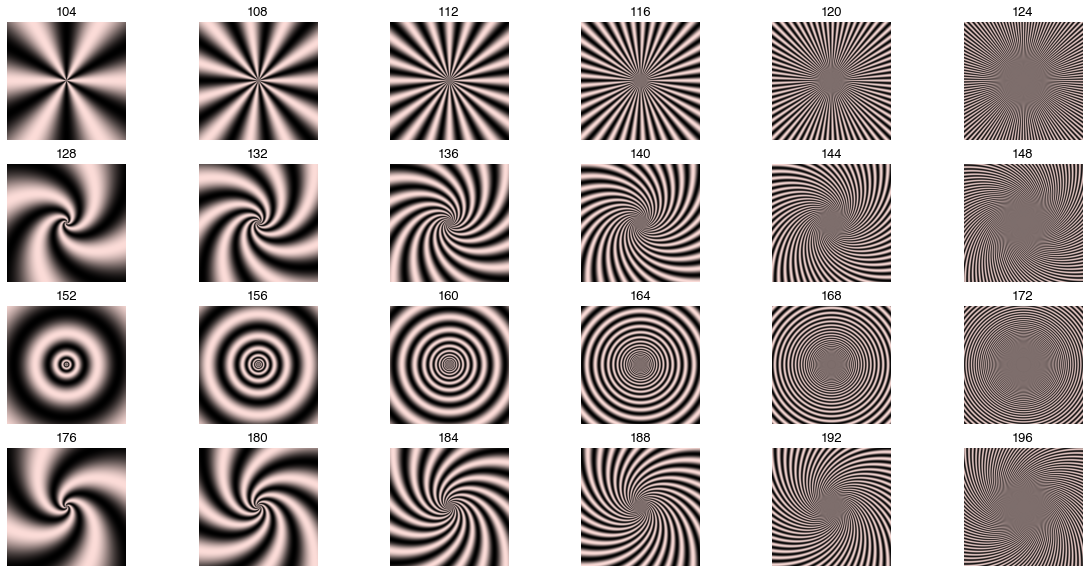

In [22]:
start_x = (1360 - 714) // 2
end_x = start_x + 714
fig, ax = plt.subplots(1,1)

center_square = data[104][:, start_x:end_x, :]
ax.imshow(center_square, cmap='gray')
ax.axis('off')
ax.set_title(f'{104+(i*4)}')





In [24]:
im_numbers = [104+(i*4) for i in range(24)]

In [26]:

from PIL import Image
for i in im_numbers:
    img = data[i]
    center_square = img[:, start_x:end_x, :]
    center_square_image = Image.fromarray(center_square)
    f = os.path.join('/Users/jh7685/Dropbox/NYU/Projects/SF/natural-scenes-dataset/stimuli', f'scaled_gratings_{i}.png')
    center_square_image.save(f, format="PNG", optimize=True)

In [3]:
stim_info = pd.read_csv('/Volumes/server/Projects/sfp_nsd/natural-scenes-dataset/nsdsyn_stim_description_corrected.csv')
stim_info.names.unique()

array(['pinwheel', 'forward spiral', 'annulus', 'reverse spiral',
       'mixtures'], dtype=object)

In [12]:
#bd_stim_info = pd.read_csv('/Volumes/server/Projects/sfp_nsd/Broderick_dataset/broderick_stim_description.csv')
#bd_stim_info['w_a'] = bd_stim_info['w_a'] * -1
#bd_stim_info.to_csv('/Volumes/server/Projects/sfp_nsd/Broderick_dataset/broderick_stim_description_corrected.csv', index=False)

In [13]:
stim_info = pd.read_csv('/Volumes/server/Projects/sfp_nsd/natural-scenes-dataset/nsdsyn_stim_description_corrected.csv')
stim_info = stim_info.drop_duplicates(subset=['class_idx'])

bd_stim_info = pd.read_csv('/Volumes/server/Projects/sfp_nsd/Broderick_dataset/broderick_stim_description_corrected.csv')
bd_stim_info = bd_stim_info.drop_duplicates(subset=['class_idx'])

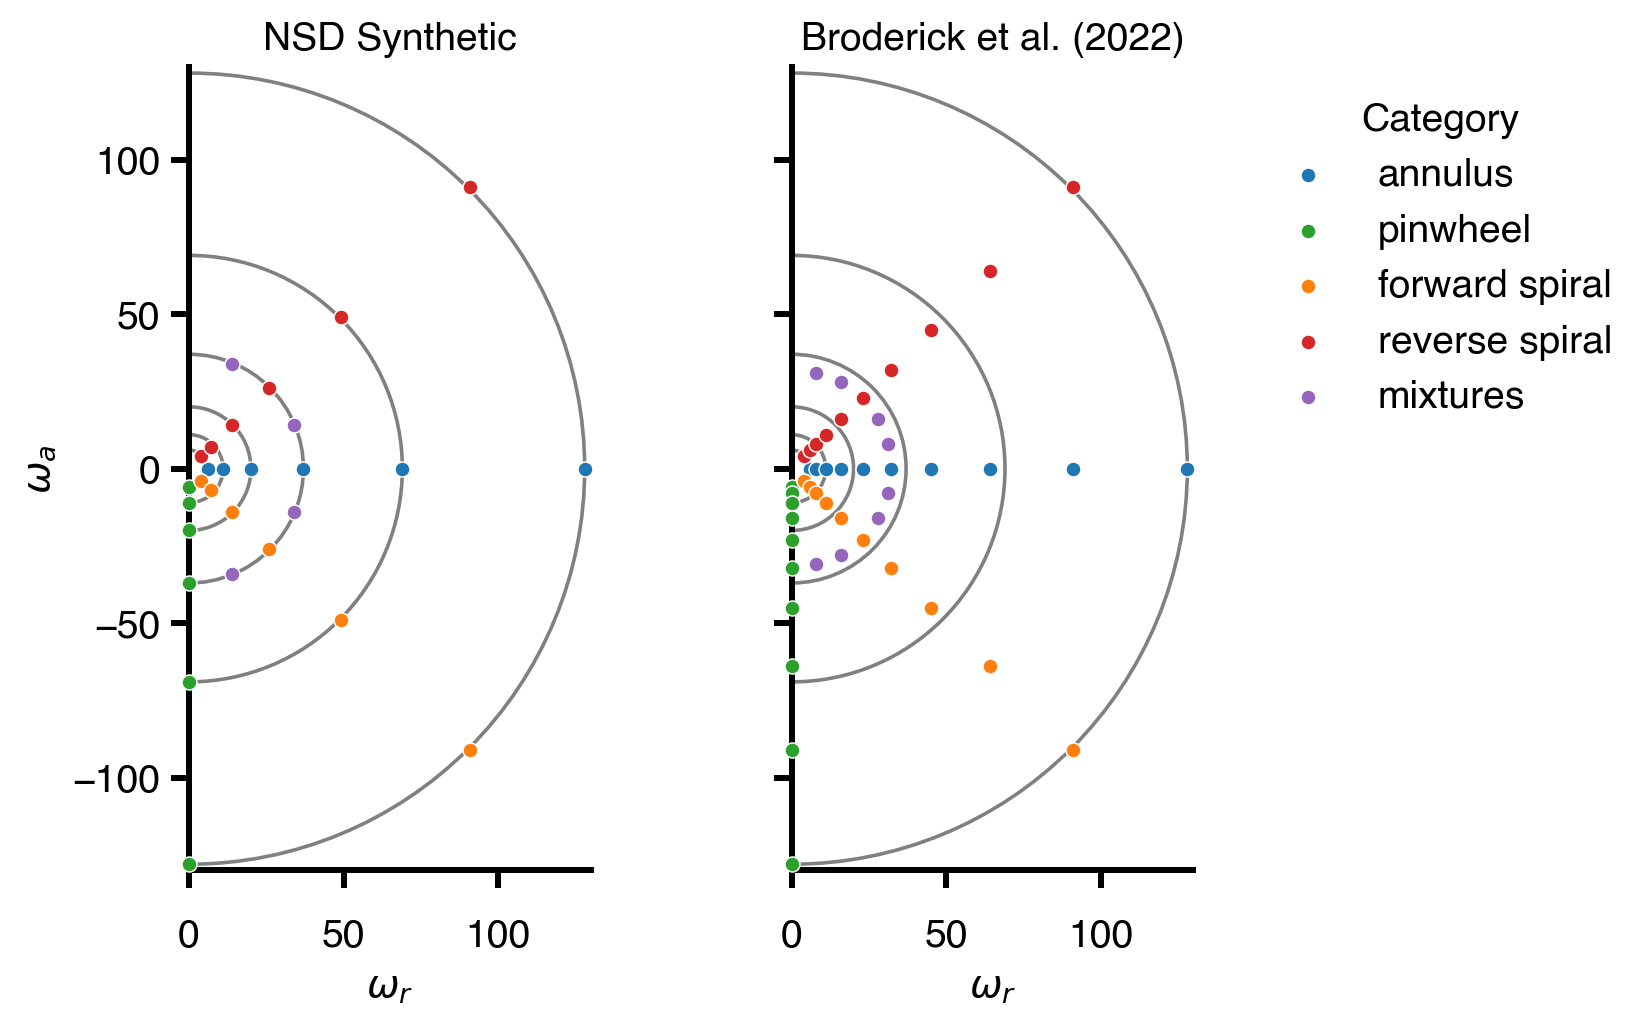

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

rc = {'text.color': 'black',
      'axes.labelcolor': 'black',
      'xtick.color': 'black',
      'ytick.color': 'black',
      'axes.edgecolor': 'black',
      'font.family': 'Helvetica',
      'axes.linewidth': 2,
      'xtick.major.pad': 10,
      'xtick.major.width': 2,
      'ytick.major.width': 2,
      'lines.linewidth': 2,
      'font.size': 13,
      'axes.titlesize': 13,
      'axes.labelsize': 13,
      'xtick.labelsize': 13,
      'ytick.labelsize': 13,
      'legend.title_fontsize': 13,
      'legend.fontsize': 13,
      'figure.titlesize': 13,
      'figure.dpi': 72 * 3,
      'savefig.dpi': 72 * 4,
      'axes.labelpad': 5,
      }

sns.set_theme(style="ticks", context='notebook', rc=rc, font_scale=1)
fig, axes = plt.subplots(1,2, sharey=True)
fig.set_size_inches(6, 6)
colors = [sns.color_palette('tab10', 10)[:][k] for k in [0,2,1,3,4]]
colors.append('gray')
for i, cat in enumerate(['annulus', 'pinwheel', 'forward spiral', 'reverse spiral', 'mixtures']):

    axes[0].scatter(stim_info.query(f'names == "{cat}"')['w_r'], 
                    stim_info.query(f'names == "{cat}"')['w_a'], label=cat, s=25, 
                    color=colors[i], edgecolors='w', linewidths=0.5, zorder=100, clip_on=False)
    axes[1].scatter(bd_stim_info.query(f'names == "{cat}"')['w_r'], 
                    bd_stim_info.query(f'names == "{cat}"')['w_a'], label=cat, s=25, 
                    color=colors[i], edgecolors='w', linewidths=0.5, zorder=100, clip_on=False)

radius_list = [6,11,20,37,69,128]  # Radius of the ring


for ax in axes:
    for radi in radius_list:
        circle1 = plt.Circle((0, 0), radi, linewidth=1.2, color='grey', clip_on=True, fill=False)
        ax.add_patch(circle1)    
    ax.set(xlim=(0, 130), ylim=(-130, 130))
    #ax.legend(bbox_to_anchor=(1.1, 0.9), frameon=False, title='Category')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_aspect('equal')
    ax.set_xlabel(r"$\omega_r$")

fig.subplots_adjust(wspace=0.5)
axes[0].set_ylabel(r"$\omega_a$")
axes[1].set_ylabel('')
axes[0].set_title('NSD Synthetic')
axes[1].set_title('Broderick et al. (2022)')
axes[1].legend(bbox_to_anchor=(1.1, 1), frameon=False, title='Category')
plt.savefig('/Volumes/server/Projects/sfp_nsd/derivatives/figures/paper/fig-1.svg', bbox_inches='tight')

